In [ ]:
from shutil import copyfile
#copyfile('../back_last_time.hdf5' , '../every.best.hdf5')
#copyfile('../every.best.hdf5', '../back_last_time.91.33.hdf5')

In [67]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint


# path to the model weights files.
top_model_weights_path = '../vgg16_weights.h5'
filepath='../every.best.hdf5'
# dimensions of our images.
img_width, img_height = 243, 243

train_data_dir = '../dataset/training_set/smo'
validation_data_dir = '../dataset/test_set/smo'

nb_train_samples = 5106
nb_validation_samples = 1355
epochs = 5
batch_size = 16



In [68]:

# build the VGG16 network

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('base_model loaded.')


base_model loaded.


In [69]:
# build a classifier model to put on top of the convolutional model
#top_model.load_weights(weights_path)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

#top_model.load_weights(top_model_weights_path, by_name=True)

In [70]:


# add the model on top of the convolutional base
# model.add(top_model)
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

#model.load_weights('../every.best.hdf5')

In [71]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)

#for layer in model.layers[:15]:    #if using 25, it mean it will not train anything!
    #layer.trainable = False

In [72]:

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [73]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [74]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [75]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5106 images belonging to 2 classes.
Found 1355 images belonging to 2 classes.


In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 243, 243, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 243, 243, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 243, 243, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 121, 121, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 121, 121, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 121, 121, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

In [77]:
# fine-tune the model
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

train_history=model.fit_generator(
    train_generator,
       ###steps_per_epoch=nb_train_samples  // batch_size,  
    steps_per_epoch=nb_train_samples, 
    epochs=epochs,
    validation_data=validation_generator,
       ###validation_steps=nb_validation_samples  // batch_size,
    validation_steps=nb_validation_samples,
    callbacks=callbacks_list)


Epoch 1/5
5106/5106 [==============================] - 1098s 215ms/step - loss: 0.2509 - acc: 0.8930 - val_loss: 0.1521 - val_acc: 0.9387

Epoch 00001: val_acc improved from -inf to 0.93875, saving model to ../every.best.hdf5
Epoch 2/5
5106/5106 [==============================] - 1157s 227ms/step - loss: 0.0701 - acc: 0.9745 - val_loss: 0.2021 - val_acc: 0.9483

Epoch 00002: val_acc improved from 0.93875 to 0.94834, saving model to ../every.best.hdf5
Epoch 3/5
5106/5106 [==============================] - 1144s 224ms/step - loss: 0.0225 - acc: 0.9925 - val_loss: 0.3049 - val_acc: 0.9432

Epoch 00003: val_acc did not improve from 0.94834
Epoch 4/5
5106/5106 [==============================] - 1147s 225ms/step - loss: 0.0152 - acc: 0.9952 - val_loss: 0.2485 - val_acc: 0.9506

Epoch 00004: val_acc improved from 0.94834 to 0.95055, saving model to ../every.best.hdf5
Epoch 5/5
5106/5106 [==============================] - 1140s 223ms/step - loss: 0.0070 - acc: 0.9979 - val_loss: 0.3006 - val_a

In [79]:
from shutil import copyfile
copyfile('../every.best.hdf5', '../vgg16.9505.hdf5')
score = model.evaluate_generator(validation_generator, nb_validation_samples/batch_size, workers=12)

scores = model.predict_generator(validation_generator, nb_validation_samples/batch_size , workers=12)
correct = 0
for i, n in enumerate(validation_generator.filenames):
    if n.startswith("cats") and scores[i][0] <= 0.5:
        correct += 1
    if n.startswith("dogs") and scores[i][0] > 0.5:
        correct += 1

print("Correct:", correct, " Total: ", len(validation_generator.filenames))
print("Loss: ", score[0], "Accuracy: ", score[1])


Correct: 0  Total:  1355
Loss:  0.30056879895429317 Accuracy:  0.9505535057549986


In [13]:
from shutil import copyfile
#copyfile('../back_last_time.hdf5' , '../every.best.hdf5')
#copyfile('../every.best.hdf5', '../vgg16.9535.hdf5')

# DEMO Start

In [81]:
from keras.models import *
from keras.layers import *
from keras.applications import ResNet50
from keras.preprocessing.image import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint


# path to the model weights files.
top_model_weights_path = '../vgg16_weights.h5'
filepath='../every.best.hdf5'
# dimensions of our images.
img_width, img_height = 243, 243

train_data_dir = '../dataset/training_set/smo'
validation_data_dir = '../dataset/test_set/smo'



model = load_model('../vgg16.94834.hdf5')


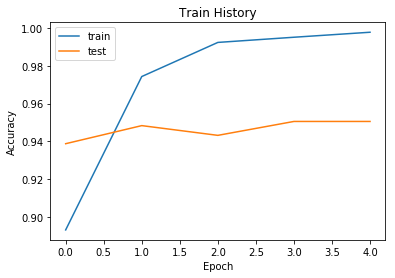

In [82]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
show_train_history('acc','val_acc')


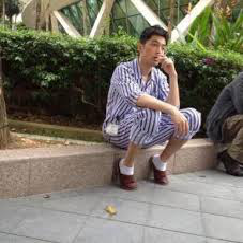

In [106]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../dataset/single_prediction/smo/s1.jpg', target_size= (img_width, img_height))
test_image

In [107]:
type(test_image)

PIL.Image.Image

In [108]:
test_image = image.img_to_array(test_image)

inputarray = test_image[np.newaxis,...] # dimension added to fit input size


In [109]:
result =  model.predict(inputarray)

In [110]:
print(result)
ans = result[0][1]
print("Predicted=", result)

print("ans=", ans)


[[0. 1.]]
Predicted= [[0. 1.]]
ans= 1.0


In [111]:
type(result)

numpy.ndarray

In [112]:
result.shape

(1, 2)

In [113]:

test_image_expand_dims = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image_expand_dims)

In [114]:
############################### new #####################3

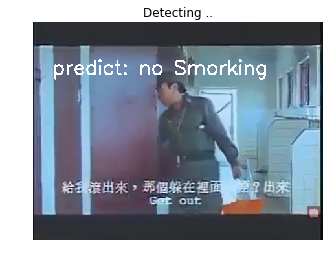

In [116]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import pandas as pd

import os
import cv2
import time
from matplotlib import pyplot as plt
import glob
from io import BytesIO
import PIL
from IPython.display import display, Image

################################################################################    
# Import the required modules
%pylab inline 
import cv2
from IPython.display import clear_output

# Grab the input device, in this case the webcam
# You can also give path to the video file
vid = cv2.VideoCapture("../dataset/source/s1.mp4")

# Put the code in try-except statements
# Catch the keyboard exception and 
# release the camera device and 
# continue with the rest of code.
#plt.figure(figsize = (10,10))
#fig = plt.figure()
#print ("fig = ") 
#<Figure size 432x288 with 0 Axes>
label_no_smorking = "predict: no Smorking"
label_smorking = "predict: Smorking!"
count = 0

#'''
try:
    while(True):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if not ret:
            # Release the Video Device if ret is false
            vid.release()
            # Message to be displayed after releasing the device
            print("Released Video Resource")
            break
            
        # Write image to folder
        #img_jpg = np.asarray(frame)
        #cv2.imwrite("../dataset/source/out/cyril_frame%d.jpg" % count, img_jpg)
        #count = count + 1
        
        #predict image here !
        resize = cv2.resize(frame, (img_width, img_height)) 
        resize = np.asarray(resize)
        test_image = image.img_to_array(resize)
        test_image_expand_dims = np.expand_dims(test_image, axis = 0)
        result = model.predict(test_image_expand_dims)
        ans = result[0][1]  #why VGG16 is fail wtih #ans = result[0][1] 
        #print(result)
        #ans = result
        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
         
        if ans > 0.45: 
        
            # put text into image 
            # https://blog.csdn.net/GAN_player/article/details/78155283
            cv2.putText(frame, label_smorking, (30, 80),  cv2.FONT_HERSHEY_SIMPLEX,1.0, (255,0, 0), 2)
            #cv2.line(影像, 開始座標, 結束座標, 顏色, 線條寬度)
            cv2.line(frame, (0, 0), (432, 0),     (255,0,0),  12)
            cv2.line(frame, (0, 0), (0, 350),     (255,0,0),  12)
            cv2.line(frame, (440, 0),(440, 440),  (255,0,0),  12)
            cv2.line(frame, (0, 330),(440, 330),(255,0,0),12)

        else:
             # put text into image 
            # https://blog.csdn.net/GAN_player/article/details/78155283
            cv2.putText(frame, label_no_smorking, (30, 80),  cv2.FONT_HERSHEY_SIMPLEX,1.0, (255,255, 255), 2)
            #cv2.line(影像, 開始座標, 結束座標, 顏色, 線條寬度)
          
        # Turn off the axis
        plt.axis('off')
        # Title of the window
        plt.title("Detecting ..")
        # Display the frame
        plt.imshow(frame)
        plt.show()
        # Display the frame until new frame is available
        clear_output(wait=True)
                
except KeyboardInterrupt:
    # Release the Video Device
    vid.release()
    # Message to be displayed after releasing the device
    #print("Released Video Resource")
    

CAP_PROP_FPS=  25
CAP_PROP_FRAME_WIDTH=  448
CAP_PROP_FRAME_HEIGHT=  336
video_total_frame (CAP_PROP_FRAME_COUNT) =  5330
video_total_frame =  213.2
video_total_tims_msec =  213200.0
smorking---------------


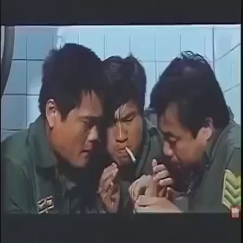

smorking---------------


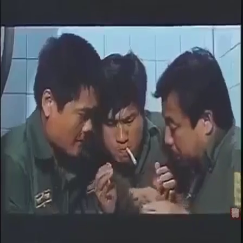

smorking---------------


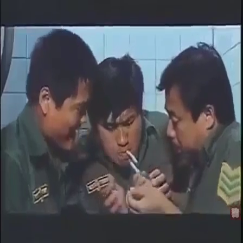

smorking---------------


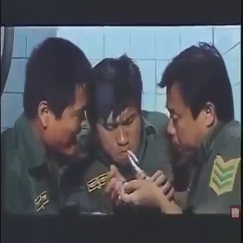

smorking---------------


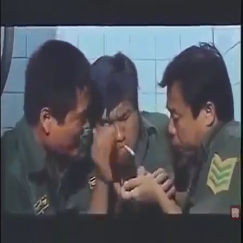

smorking---------------


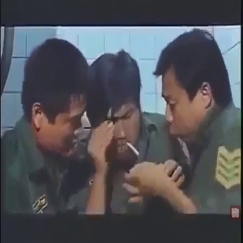

smorking---------------


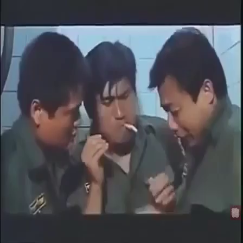

smorking---------------


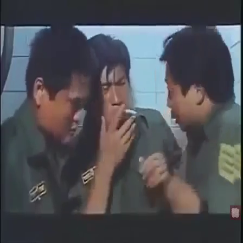

smorking---------------


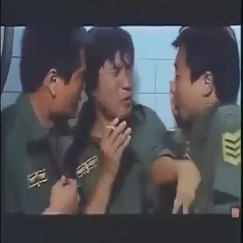

smorking---------------


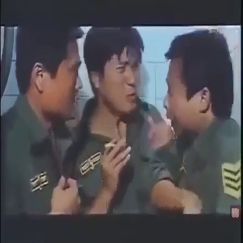

smorking---------------


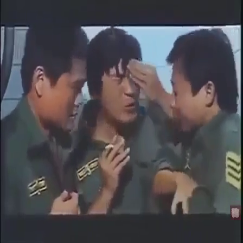

smorking---------------


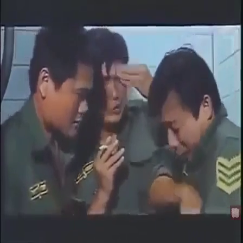

smorking---------------


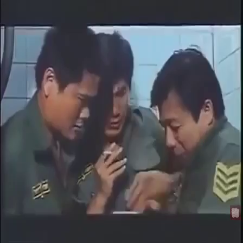

smorking---------------


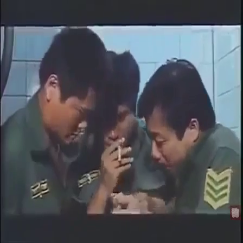

smorking---------------


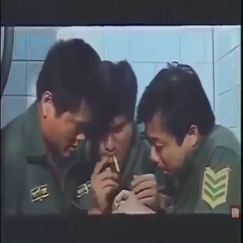

smorking---------------


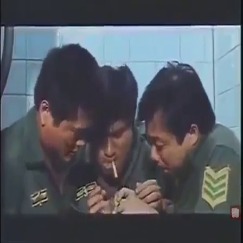

smorking---------------


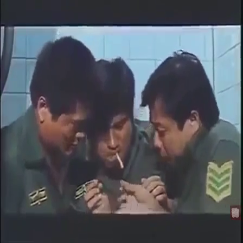

smorking---------------


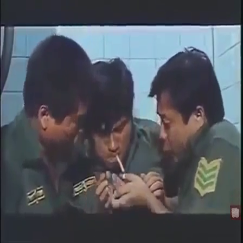

smorking---------------


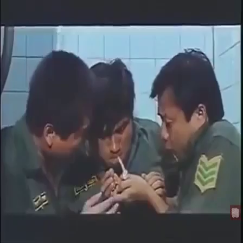

smorking---------------


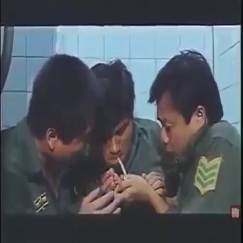

smorking---------------


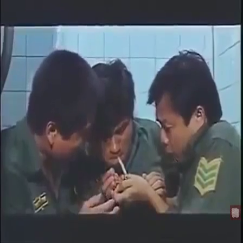

smorking---------------


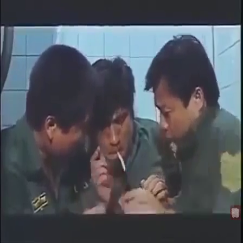

smorking---------------


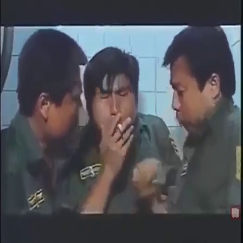

smorking---------------


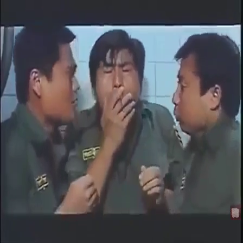

smorking---------------


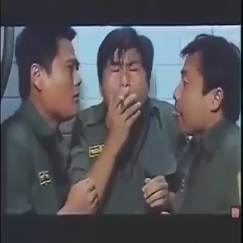

smorking---------------


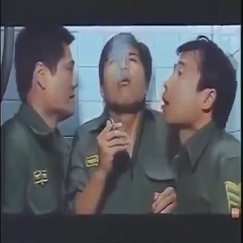

smorking---------------


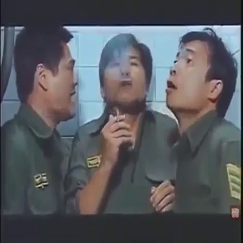

smorking---------------


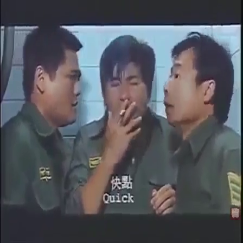

smorking---------------


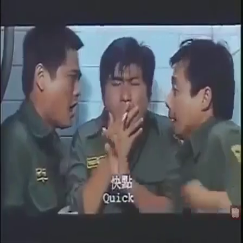

smorking---------------


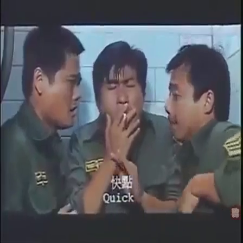

smorking---------------


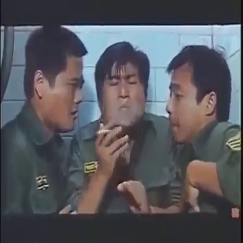

smorking---------------


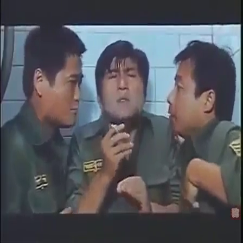

smorking---------------


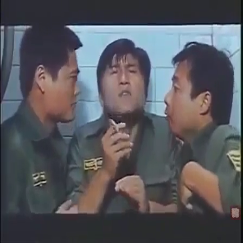

smorking---------------


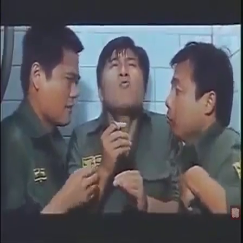

smorking---------------


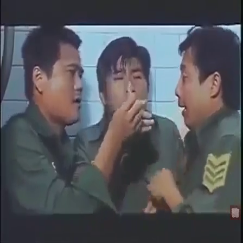

smorking---------------


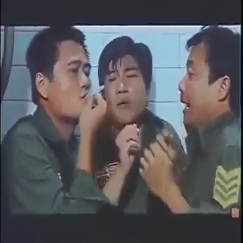

smorking---------------


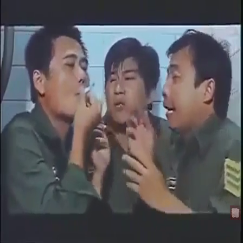

smorking---------------


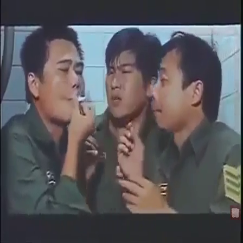

smorking---------------


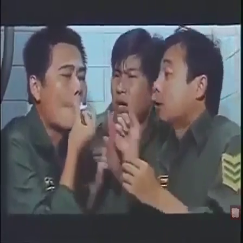

smorking---------------


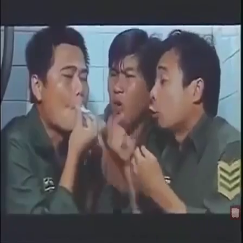

smorking---------------


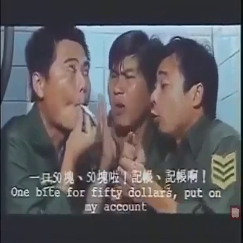

smorking---------------


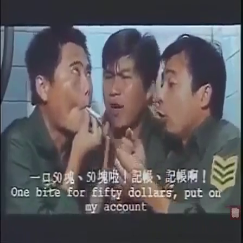

smorking---------------


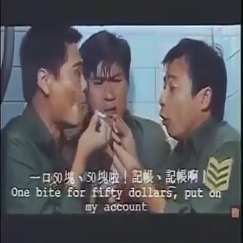

smorking---------------


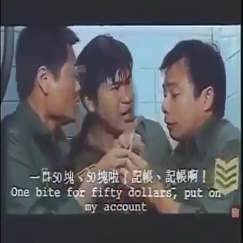

smorking---------------


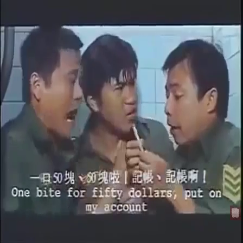

smorking---------------


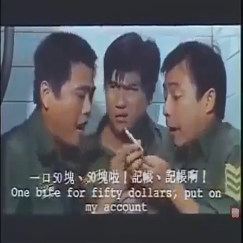

smorking---------------


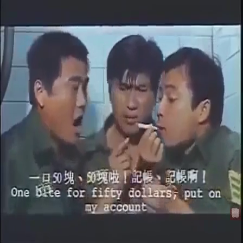

smorking---------------


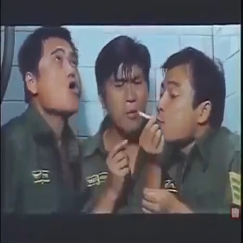

smorking---------------


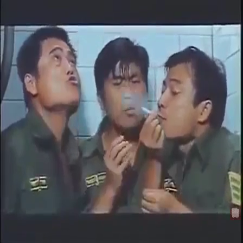

smorking---------------


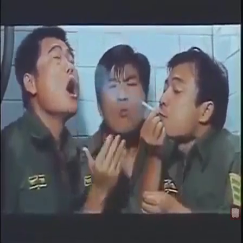

smorking---------------


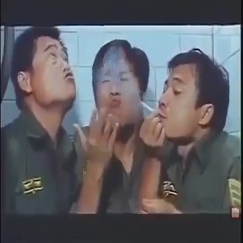

smorking---------------


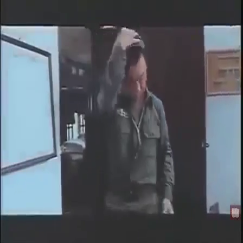

smorking---------------


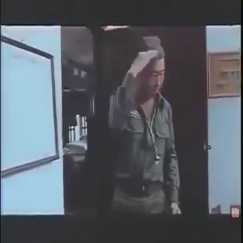

smorking---------------


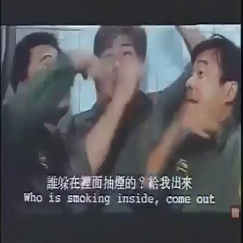

smorking---------------


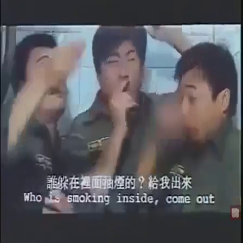

smorking---------------


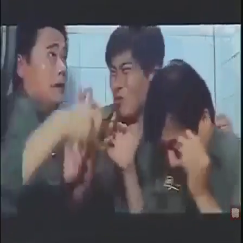

smorking---------------


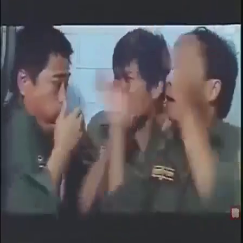

smorking---------------


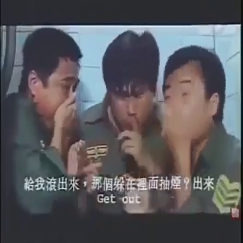

smorking---------------


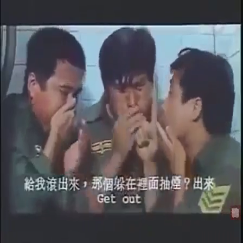

smorking---------------


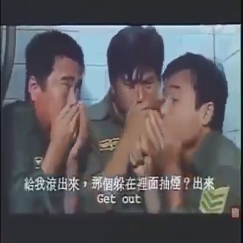

smorking---------------


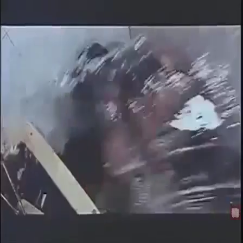

smorking---------------


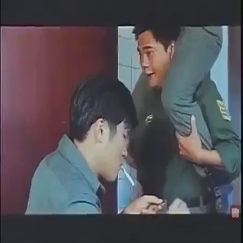

smorking---------------


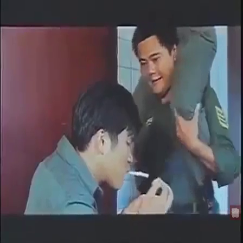

smorking---------------


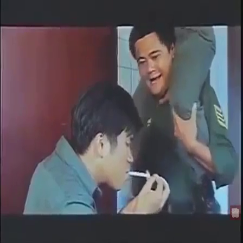

smorking---------------


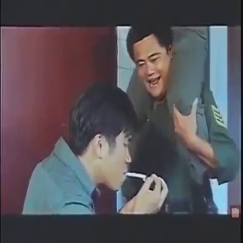

smorking---------------


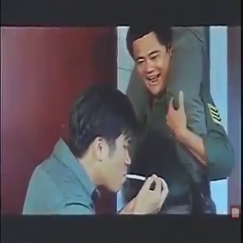

smorking---------------


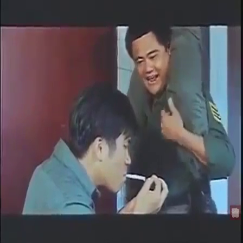

smorking---------------


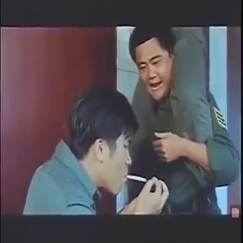

smorking---------------


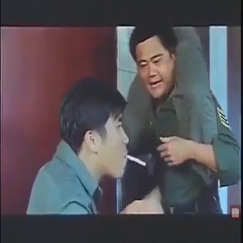

smorking---------------


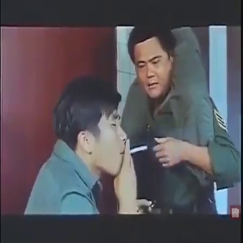

smorking---------------


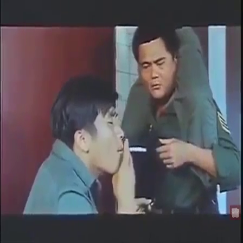

smorking---------------


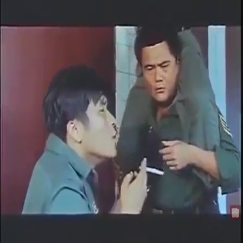

smorking---------------


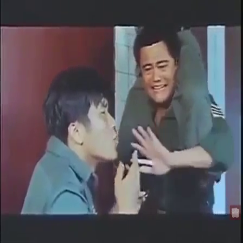

smorking---------------


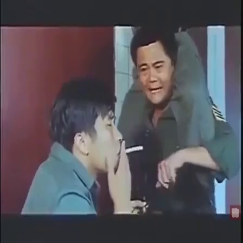

smorking---------------


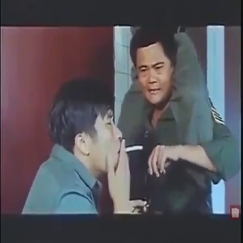

smorking---------------


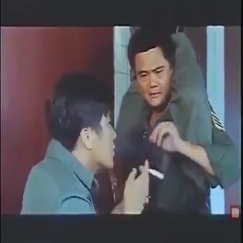

smorking---------------


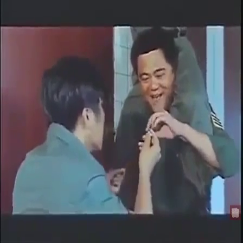

smorking---------------


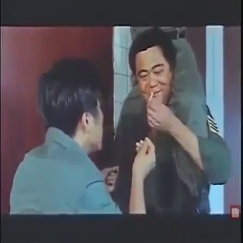

smorking---------------


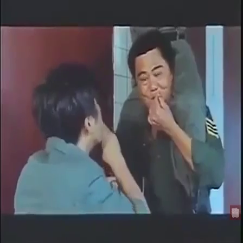

smorking---------------


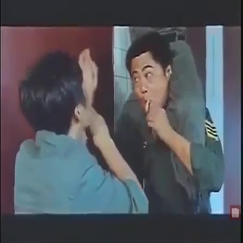

smorking---------------


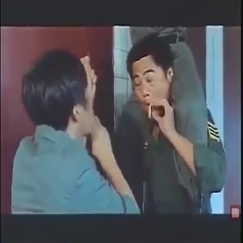

smorking---------------


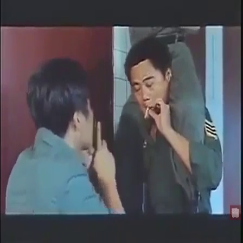

smorking---------------


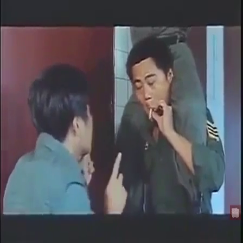

smorking---------------


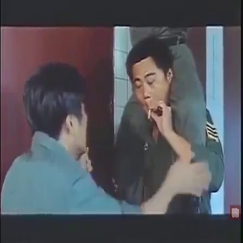

smorking---------------


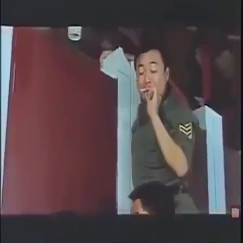

smorking---------------


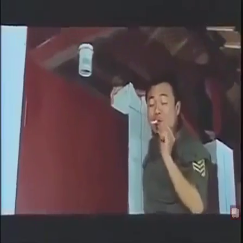

smorking---------------


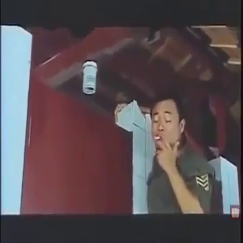

smorking---------------


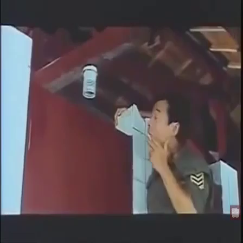

smorking---------------


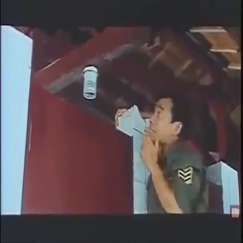

smorking---------------


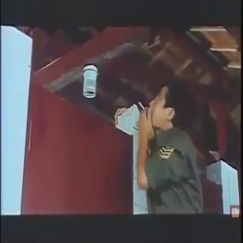

smorking---------------


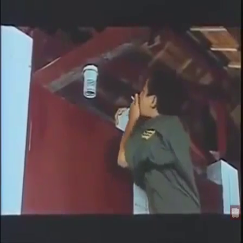

smorking---------------


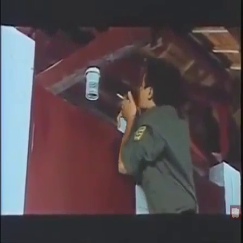

smorking---------------


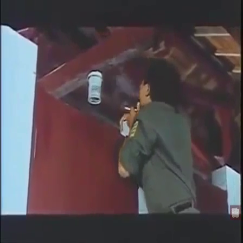

smorking---------------


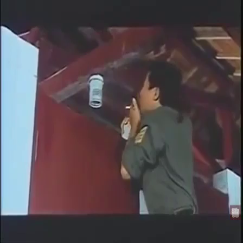

smorking---------------


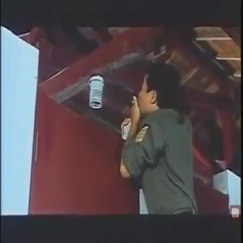

smorking---------------


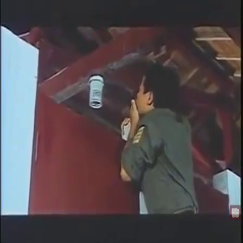

smorking---------------


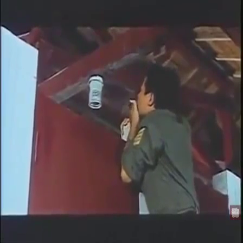

smorking---------------


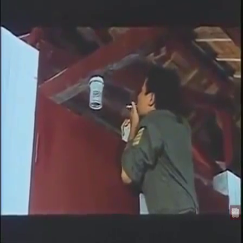

smorking---------------


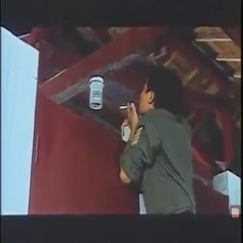

smorking---------------


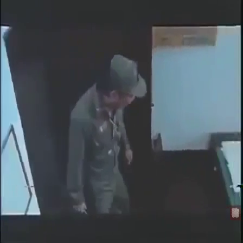

smorking---------------


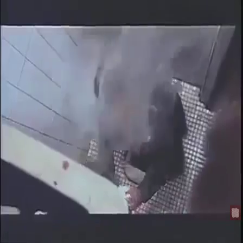

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [117]:
from matplotlib import pyplot as plt
import glob
import numpy as np
import os.path as path
from scipy import misc
import os
import cv2
import time
from keras.preprocessing import image
from io import BytesIO
import PIL
from IPython.display import display, Image


video_data_dir = '../dataset/source/s1.mp4'
#-------------------------------------------------------------------
vidcap = cv2.VideoCapture(video_data_dir)
#-------------------------------------------------------------------
video_fps= int(vidcap.get(cv2.CAP_PROP_FPS))
print ("CAP_PROP_FPS= ",video_fps)
#-------------------------------------------------------------------
#video_pos = int(vidcap.get(cv2.CAP_PROP_POS_MSEC))
#print ("CAP_PROP_POS_MSEC= ",video_pos)
#-------------------------------------------------------------------
video_w = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
print ("CAP_PROP_FRAME_WIDTH= ",video_w)
#-------------------------------------------------------------------
video_h = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print ("CAP_PROP_FRAME_HEIGHT= ",video_h)
#-------------------------------------------------------------------
video_total_frame = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
print ("video_total_frame (CAP_PROP_FRAME_COUNT) = ",video_total_frame)
#-------------------------------------------------------------------
video_total_tims=  video_total_frame / video_fps
print ("video_total_frame = ",video_total_tims)
video_total_tims_msec = video_total_tims * 1000
print ("video_total_tims_msec = ",video_total_tims_msec)
#-------------------------------------------------------------------
#video_total_times = int(vidcap.get(cv2.CAP_PROP_POS_MSEC))
#print ("CV_CAP_PROP_POS_MSEC = ",video_total_times)


msec_count = 0

while msec_count <= video_total_tims_msec:

    vidcap.set(cv2.CAP_PROP_POS_MSEC, msec_count) 
    success,imagecv2 = vidcap.read()
    resize = cv2.resize(imagecv2, (img_width, img_height)) 
    test_image = image.img_to_array(resize)
    test_image_expand_dims = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image_expand_dims)
    ans = result[0][1]
    #ans = result

    #print(ans)
    
    #save image here
    #img_jpg = np.asarray(resize)    
    #cv2.imwrite("../dataset/tmp/frame%d.jpg" % msec_count, img_jpg)
  
    if ans > 0.45 :
        
        #convert RGB of image for IPL
        frame = cv2.cvtColor(resize, cv2.COLOR_BGR2RGB) ### for IPL.show!!!

        print ("smorking---------------")
        #plt.imshow(img)
        im = PIL.Image.fromarray(frame)
        bio = BytesIO()
        im.save(bio, format='png')
        display(Image(bio.getvalue(), format='png'))        
        
    else :
        '''
        print ("no smorking here ---------------")

        #convert RGB of image for IPL
        frame = cv2.cvtColor(resize, cv2.COLOR_BGR2RGB) ### for IPL.show!!!

        print ("no smorking---------------")
        #plt.imshow(img)
        im = PIL.Image.fromarray(frame)
        bio = BytesIO()
        im.save(bio, format='png')
        display(Image(bio.getvalue(), format='png'))  
        
        print ("-------------------------------------------------")
        '''
    msec_count = msec_count + (400)


print ( "done, counts are", msec_count)


In [ ]:
#model.save_weights(top_model_weights_path)
#model.save_weights('../every.best.hdf5')